<a href="https://colab.research.google.com/github/altynnnay/CancerMe-/blob/main/CancerMe_Prototype_Eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# CancerMe – AI Skin Cancer Detection
# Author: Aralbek Altynay
# Prototype project using deep learning and Gradio
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [62]:
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (4).json


{'kaggle (4).json': b'{"username":"altynayaralbek","key":"578feea0f2374b922a3eaab98b1229bc"}'}

In [63]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [64]:
import pandas as pd
import os

base = '/content'
meta = pd.read_csv(os.path.join(base, 'HAM10000_metadata.csv'))

<ipython-input-65-25978b34939d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x="dx", kind="count", palette="bright", data=meta)


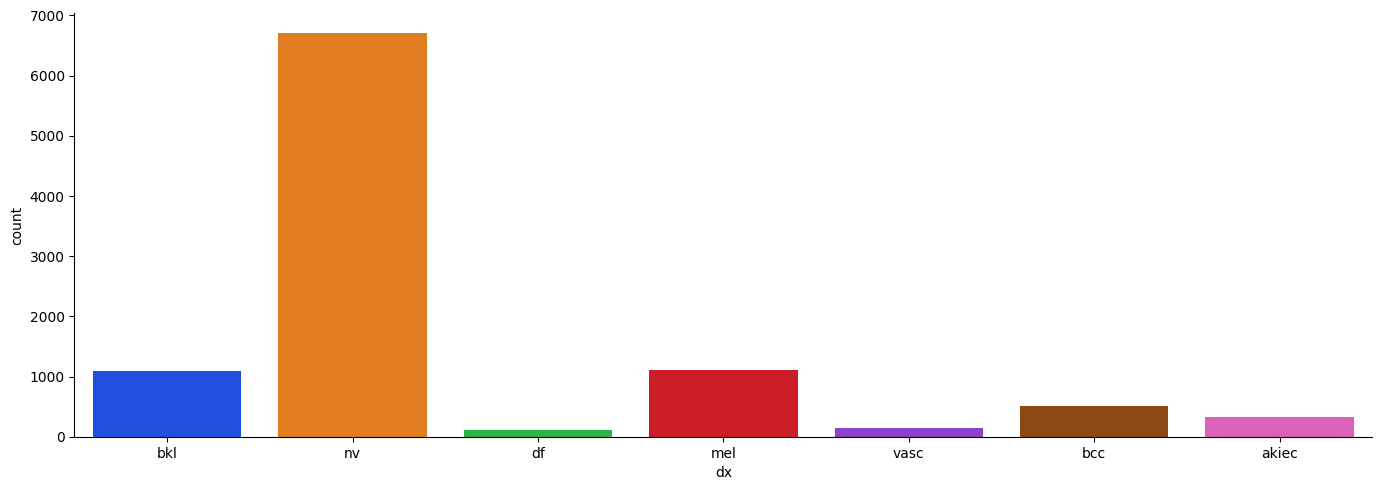

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
...
import seaborn as sns

sns.catplot(x="dx", kind="count", palette="bright", data=meta)
plt.gcf().set_size_inches(16, 5)

In [66]:
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

img_size = 64
X = []
y = []

for i in tqdm(meta['image_id']):
    img_path1 = f'/content/HAM10000_images_part_1/{i}.jpg'
    img_path2 = f'/content/HAM10000_images_part_2/{i}.jpg'
    img_path = img_path1 if os.path.exists(img_path1) else img_path2
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (img_size, img_size))
        X.append(img)

        label = meta[meta['image_id'] == i]['dx'].values[0]
        y.append(label)

X = np.array(X)
y = np.array(y)

100%|██████████| 10015/10015 [01:59<00:00, 83.70it/s]


In [67]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)


print(le.classes_)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0


model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,626,055 (6.20 MB)

 Trainable params: 1,626,055 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(X_train_scaled, y_train_cat,
                    epochs=10,
                    validation_data=(X_test_scaled, y_test_cat))

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 187ms/step - accuracy: 0.6538 - loss: 1.1261 - val_accuracy: 0.6695 - val_loss: 0.9438
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - accuracy: 0.6784 - loss: 0.9238 - val_accuracy: 0.6755 - val_loss: 0.8586
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 180ms/step - accuracy: 0.6876 - loss: 0.8591 - val_accuracy: 0.6875 - val_loss: 0.8299
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 84s 189ms/step - accuracy: 0.6989 - loss: 0.7964 - val_accuracy: 0.7019 - val_loss: 0.7874
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 185ms/step - accuracy: 0.7111 - loss: 0.7731 - val_accuracy: 0.6965 - val_loss: 0.8106
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.7207 - loss: 0.7596 - val_accuracy: 0.7159 - val_loss: 0.7484
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 183ms/step - accuracy: 0.7373 - loss: 0.7070 - val_accuracy: 0.6830 - val_loss: 0.8173
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - accuracy: 0.7385 - loss: 0

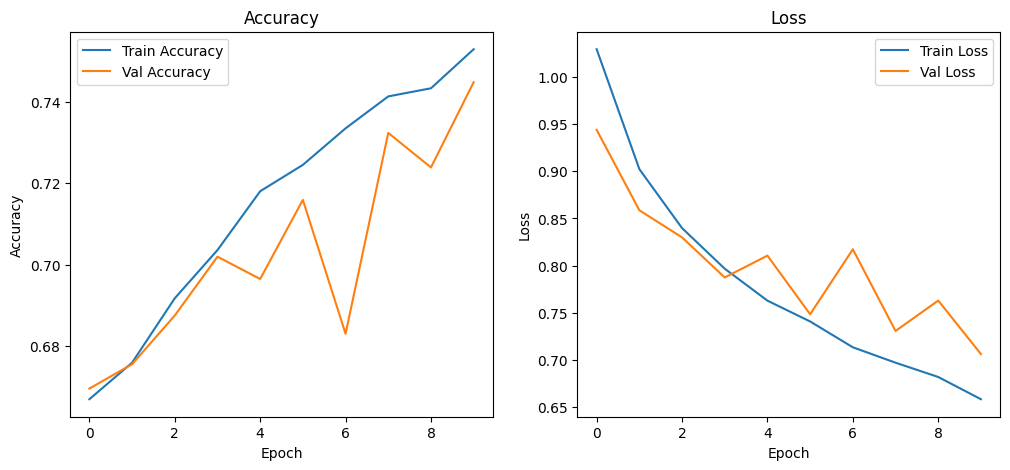

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

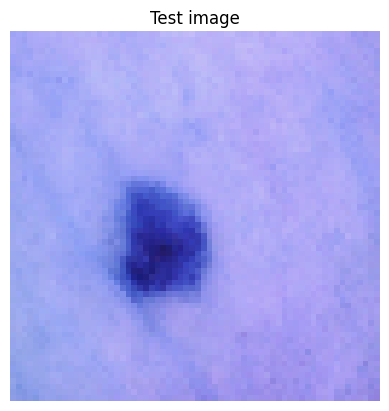

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Predicted class: nv
Actual class:     nv


In [72]:

import random

idx = random.randint(0, len(X_test_scaled) - 1)
img = X_test_scaled[idx]


plt.imshow(img)
plt.axis('off')
plt.title("Test image")
plt.show()


pred = model.predict(np.expand_dims(img, axis=0))
pred_class = np.argmax(pred)

print("Predicted class:", le.classes_[pred_class])
print("Actual class:    ", le.classes_[y_test[idx]])

In [73]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import cv2
import numpy as np


class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
def predict_skin_disease(img):

    img_resized = cv2.resize(img, (64, 64))
    img_scaled = np.array(img_resized) / 255.0
    img_input = np.expand_dims(img_scaled, axis=0)


    prediction = model.predict(img_input)
    class_index = np.argmax(prediction)
    class_name = class_labels[class_index]

    return f"Predicted diagnosis: {class_name}"


interface = gr.Interface(
    fn=predict_skin_disease,
    inputs=gr.Image(type="numpy"),
    outputs="text",
    title="CancerMe - Skin Cancer Prediction",
    description="Upload a skin lesion image to receive an AI-powered diagnosis"
)

interface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6c432ad77ed0c8436a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
